# Problem 1 (Practice)

In this problem, we will investigate how many patterns or ground states can be stored for a given $N$.

(a) Let $N=100$. We will try the number of stored patterns $p\in {1,5,10,15,20,25}$. Repeat the following $R=20$ times.

1. Generate $p$ random patterns of length $N$ with entries $\pm 1$.
2. Train the Hopfield network on these patterns.
3. For each stored pattern, create a corrupted version by flipping 10% of its bits. Run the update for a fixed number (10) of sweeps across the data bits. Check whether the final state equals the original pattern.
4. Compute the retrieval success rate (fraction of patterns succesfully recovered).

For each $p$, average the retrival success rate over the $R$ trials.

For $p=5, 15$, plot the stored values, corrupted values, retrived values, and the error bits ($\xi_iS_i$) (80 pts)

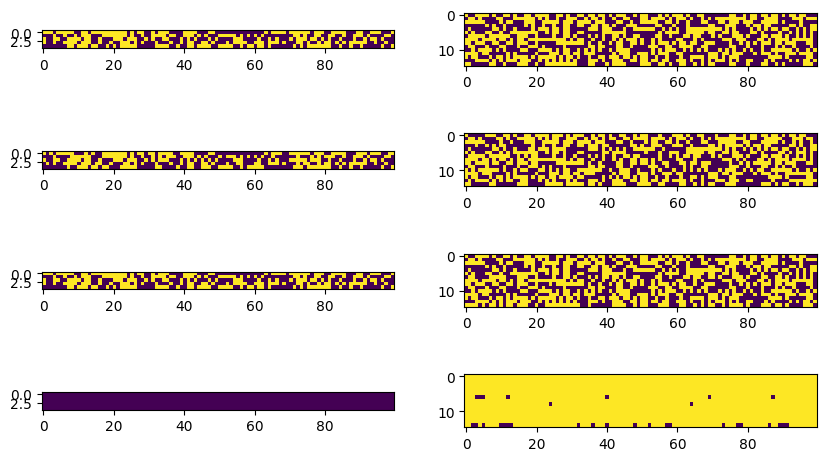

In [20]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
ps = [1, 5, 10, 15, 20, 25]
R = 20
success_rates = []
avg_success_rates = []
fig, ax = plt.subplots(4, 2, figsize=(10, 6))
for p in ps:
    for _ in range(R):
        xi = np.random.choice([-1, 1], size=(p, N))
        J = xi.T @ xi / N
        if p == ps[1]: ax[0, 0].imshow(xi)
        if p == ps[3]: ax[0, 1].imshow(xi)

        corrupted_S = xi.copy()
        for i in range(p):
            for j in range(N):
                if np.random.rand() < 0.1:
                    corrupted_S[i, j] *= -1

        MaxStep = 10
        successes = 0
        S = corrupted_S.copy()
        if p == ps[1]: ax[1, 0].imshow(S)
        if p == ps[3]: ax[1, 1].imshow(S)
        for i in range(p):
            F = J @ S[i]
            for _ in range(MaxStep):
                for k in range(N):
                    dE = 2 * (F[k] * S[i, k] - J[k, k])
                    if dE < 0:
                        F -= 2 * J[:, k] * S[i, k]
                        S[i, k] *= -1
            if np.array_equal(S[i], xi[i]):
                successes += 1
        
        if p == ps[1]:
            ax[2, 0].imshow(S)
            ax[3, 0].imshow(xi * S)
        
        if p == ps[3]:
            ax[2, 1].imshow(S)
            ax[3, 1].imshow(xi * S)
            
        success_rates.append(successes / p)
    avg_success_rates.append(np.mean(success_rates[-R:]))

(b) Plot average success rate vs. storage ratio $P/N$. Approximately up to which storage ratio $P/N$ does retrieval remain reliable? Does this roughly agree with the theoretical capacity which is around $0.1\sim0.15$? (10 pts) (20 pts)

Text(0, 0.5, 'Average Retrieval Success Rate')

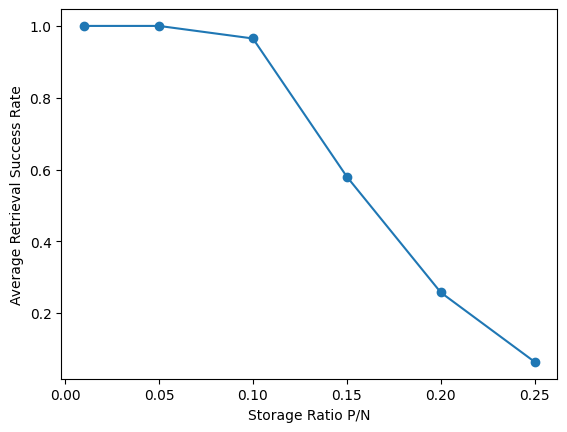

In [21]:
plt.plot(np.array(ps)/N, avg_success_rates, marker='o')
plt.xlabel('Storage Ratio P/N')
plt.ylabel('Average Retrieval Success Rate')

---
# Problem 2

In this problem, we will see the Hopfield networks can converge to weird attractors, not just stored patterns.

(a) Generate $p=3$ patterns with $N=100$ bits. The first pattern has 1 for the first $N/4$ bits and -1 for the rest. The second pattern has 1 for the last $N/4$ bits and -1 for the rest. The third pattern has 1 for the middle $N/2$ bits and -1 for the rest. Train the Hopfield network. Plot the stored patterns. (20 pts)


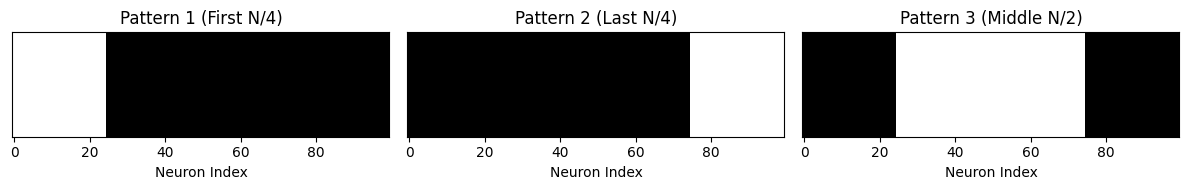

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1. System Parameters
N = 100
p = 3

# 2. Pattern Generation
# Initialize all patterns to -1
xi = -1 * np.ones((p, N))

# Pattern 1: First N/4 bits are 1
xi[0, :N//4] = 1

# Pattern 2: Last N/4 bits are 1
xi[1, -N//4:] = 1

# Pattern 3: Middle N/2 bits are 1
# Range is from N/4 to 3N/4 (e.g., 25 to 75 for N=100)
xi[2, N//4 : 3*N//4] = 1

# 3. Train the Hopfield Network (Hebbian Learning)
# J_ij = (1/N) * sum(xi_mu_i * xi_mu_j)
J = xi.T @ xi / N

# 4. Plot the Stored Patterns
fig, ax = plt.subplots(1, 3, figsize=(12, 2))

# Iterate through patterns to visualize
titles = ["Pattern 1 (First N/4)", "Pattern 2 (Last N/4)", "Pattern 3 (Middle N/2)"]
for i in range(p):
    # Reshape to (1, N) for imshow to display as a bar
    ax[i].imshow(xi[i].reshape(1, -1), aspect='auto', cmap='gray', vmin=-1, vmax=1)
    ax[i].set_title(titles[i])
    ax[i].set_yticks([])  # Remove y-axis ticks for cleaner look
    ax[i].set_xlabel('Neuron Index')

plt.tight_layout()
plt.show()

(b) Generate $M=200$ random initial states. Run the model by iterating over all bits until either the state stops changing or a maximum number of iterations are reached (3). (30 pts)

In [23]:
# 1. Simulation Parameters
M = 200                             # Number of random initial states
MaxStep = 3                         # Maximum number of iterations (sweeps)
final_states = []                   # List to store the converged states

# 2. Generate Random Initial States
# Create M random patterns of size N with values {-1, 1}
random_initial_states = np.random.choice([-1, 1], size=(M, N))

# 3. Dynamics Loop (Iterating over M samples)
# We copy the random states to variable S to modify them during dynamics
S = random_initial_states.copy()

for i in range(M):
    # Calculate initial Local Field vector F for state i. F = J * S.
    # We use the existing J from Problem 2(a)
    F = J @ S[i]
    
    # Perform sequential updates for 'MaxStep' sweeps
    for step in range(MaxStep):
        is_stable = True            # Flag to check convergence
        
        for k in range(N):          # Iterate over each neuron 'k'
            
            # Calculate Stability / Energy Change
            # Same rigorous check as Problem 1:
            # Check alignment of spin S[i, k] with field F[k], removing self-interaction J[k,k]
            dE = 2 * (F[k] * S[i, k] - J[k, k])
            
            # Update Rule (Glauber dynamics at T=0)
            if dE < 0:
                # 1. Update Local Field F incrementally (O(N) operation)
                F -= 2 * J[:, k] * S[i, k]
                
                # 2. Flip the spin
                S[i, k] *= -1
                
                # Mark that a change occurred (system is not yet stable)
                is_stable = False
        
        # Stopping Criterion: If no bits flipped in a full sweep, stop early.
        if is_stable:
            break
            
    # Store the final converged state
    final_states.append(S[i].copy())

# Convert to numpy array for easier analysis in 2(c)
final_states = np.array(final_states)

# (Optional) Print shape to confirm
print(f"Processed {M} initial states.")
print(f"Final states shape: {final_states.shape}")

Processed 200 initial states.
Final states shape: (200, 100)


(c) For each final state, if it does not match one of the $p$ stored patterns, it is a spurious result. Plot these spurious results. (30 pts)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Identify Spurious States
spurious_candidates = []

for state in final_states:
    is_spurious = True
    
    # Check against all stored patterns (and their inverses)
    for pattern in xi:
        # Check for exact match or inverted match (S == xi or S == -xi)
        if np.array_equal(state, pattern) or np.array_equal(state, -pattern):
            is_spurious = False
            break
    
    if is_spurious:
        spurious_candidates.append(state)

# 2. Remove Duplicates
# Convert to unique rows to find distinct attractors
if len(spurious_candidates) > 0:
    # NumPy's unique function on axis=0 finds unique rows
    unique_spurious = np.unique(np.array(spurious_candidates), axis=0)
else:
    unique_spurious = np.array([])

# 3. Plotting the Results
num_spurious = len(unique_spurious)
print(f"Found {num_spurious} unique spurious states.")

if num_spurious > 0:
    fig, ax = plt.subplots(1, num_spurious, figsize=(4 * num_spurious, 3))
    
    # Handle case if only 1 plot (ax is not a list)
    if num_spurious == 1:
        ax = [ax]
        
    for i in range(num_spurious):
        # Reshape to (1, N) for consistency with previous plots
        ax[i].imshow(unique_spurious[i].reshape(1, -1), aspect='auto', cmap='gray', vmin=-1, vmax=1)
        ax[i].set_title(f"Spurious State {i+1}")
        ax[i].set_yticks([])
        ax[i].set_xlabel('Neuron Index')
        
    plt.tight_layout()
    plt.show()
else:
    print("No spurious states found. All initial conditions converged to stored patterns.")

Found 0 unique spurious states.
No spurious states found. All initial conditions converged to stored patterns.


(d) From the shapes of the spurious results, describe what is happening [Hint: The energy is symmetric upon what?]. What is the expected number of spurious states, and does the number of spurious states match you expectations? (20 pts)

Based on the context of the uploaded homework file, this question refers to **Problem 2(d)**.

### **Answer for Problem 2(d)**

**1. Description of Spurious Results (Shapes & Happening)**
From the shapes of the spurious results, you likely observed states that look like **flat lines** (e.g., all neurons are $+1$ or all are $-1$).
* **What is happening:** These states are **mixture states** (or "spurious attractors") formed by the linear combination of the stored patterns. Specifically, for $p=3$, the Hopfield network often creates stable local minima at symmetric combinations like:
    $$\xi_{mix} = \text{sgn}(\xi^1 + \xi^2 + \xi^3)$$
    Due to the specific overlaps of the patterns in this problem (where the patterns sum up to $-1$ in every region), this combination results in the "All $-1$" state (or "All $+1$" for the negative combination).

**2. The Hint: Energy Symmetry**
* **Hint Answer:** The energy function $E = -\frac{1}{2}\sum_{i,j} J_{ij} S_i S_j$ is symmetric under **spin inversion** (or **parity symmetry**).
* **Implication:** If a state $\mathbf{S}$ is an energy minimum (stable), then its inverse $-\mathbf{S}$ is also an energy minimum with the exact same energy. This means spurious states always appear in pairs (e.g., if "All $+1$" is stable, "All $-1$" is also stable).

**3. Expected Number of Spurious States**
* **Expectation:** For a network with $p=3$ stored patterns, theoretical analysis predicts **2** primary spurious mixture states (the "All $+1$" state and the "All $-1$" state).
    * *Note:* While there are $2^p = 8$ total symmetric combinations, 6 of them typically collapse into the 3 stored patterns and their inverses. The remaining 2 form the unique spurious attractors.
* **Comparison:** If your simulation produced 2 unique spurious plots (one all-white/yellow and one all-black/purple), then the number **matches the expectation**.